# Low-Rank Optimal Transport through Factor Relaxation with Latent Coupling


In this tutorial, we explore the low-rank LRSinkhorn solver with Factor Relaxation and Latent Coupling (FRLC), inspired by **[Scetbon et al., 2021]**. 

This approach extends the classical Sinkhorn algorithm by computing low-rank optimal transport couplings through a structured factorization. Rather than solving for a full-rank transport matrix ($P$) (as done in the Sinkhorn algorithm) to minimize a cost ( $C$ ), the FRLC solver restricts the set of feasible transport plans to those adopting a latent coupling factorization of the form: $$P = Q \times \text{diag}(1 / g_Q) \times T \times \text{diag}(1 / g_R) , R^\top$$ where: $Q \in \mathbb{R}+^{n \times r}$ and $R \in \mathbb{R}+^{m \times r}$ are two thin matrices representing the low-rank factors, $T \in \mathbb{R}_+^{r \times r}$ is a latent coupling matrix,$g_Q \in \mathbb{R}+^r$ and $g_R \in \mathbb{R}+^r$ are marginal vectors ensuring proper normalization.

This factorization allows for efficient computation of transport plans while maintaining interpretability through the latent coupling $T$. The FRLC algorithm iteratively updates $Q$, $R$, and $T$ to approximate the optimal transport plan while respecting the low-rank constraint.

## Problem formulation

In [ ]:
from typing import Tuple

import jax
import jax.numpy as jnp
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from ott.geometry import geometry, pointcloud
from ott.initializers.linear.initializers_lr import KMeansInitializer
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.tools import plot


In [ ]:
def create_points(rng, n: int, m: int, d: int) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Generate two point clouds and their associated normalized weight distributions.

    Args:
        rng (): jax seed
        n (int): number of points in the source distribution.
        m (int): number of points in the target distribution.
        d (int): dimensionality of each point.

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]: x, y, a, b
    """
    rngs = jax.random.split(rng, 4)
    x = jax.random.normal(rngs[0], (n, d)) + 1
    y = jax.random.uniform(rngs[1], (m, d))
    a = jax.random.uniform(rngs[2], (n,))
    b = jax.random.uniform(rngs[3], (m,))
    a = a / jnp.sum(a)
    b = b / jnp.sum(b)
    return x, y, a, b


In [ ]:
rng = jax.random.key(42)
n, m, d = 25, 20, 2
x, y, a, b = create_points(rng, n=n, m=m, d=d)

geom = pointcloud.PointCloud(x, y, epsilon=0.1)
prob = linear_problem.LinearProblem(geom, a=a, b=b)

C = geom.cost_matrix

r = 5
gamma = 10
epsilon = 1e-3

tau = 1.0
delta = 1e-3
max_iter = 30


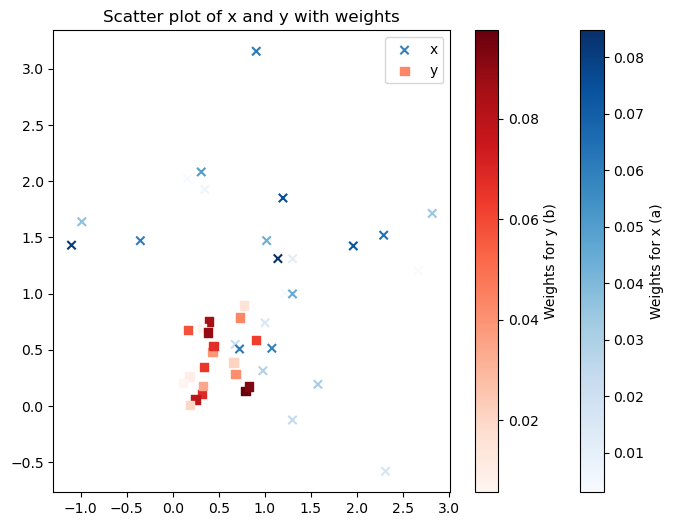

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot for x and y with color mapping
scatter_x = ax.scatter(x[:, 0], x[:, 1], c=a, cmap="Blues", label="x", marker="x")
scatter_y = ax.scatter(y[:, 0], y[:, 1], c=b, cmap="Reds", label="y", marker="s")

# Add colorbars for each scatter plot
cbar_x = plt.colorbar(scatter_x, ax=ax, label="Weights for x (a)", orientation="vertical")
cbar_y = plt.colorbar(scatter_y, ax=ax, label="Weights for y (b)", orientation="vertical")

# Add labels and legend
plt.legend()
plt.title("Scatter plot of x and y with weights")
plt.show()


## Low-Rank Sinkhorn Algorithm with Latent Coupling

We reproduce the method presented in the article including the deterministic initialization proposed. We use tips seen on the solvers implementation in ott such as, removing the $\frac{1}{\gamma_k^2}$ factor in the delta_diff function.

In [ ]:
def initialize_couplings(
    rng, a: jnp.ndarray, b: jnp.ndarray, gQ: jnp.ndarray, gR: jnp.ndarray, r: int
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """Algorithm 6 from the article

    Args:
        rng (_type_): random key
        a (jnp.ndarray)
        b (jnp.ndarray)
        gQ (jnp.ndarray)
        gR (jnp.ndarray)
        r (int): rank

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]: the initial couplings.
    """
    # algo 6 in the article

    rngs = jax.random.split(rng, 3)
    n, m = a.shape[0], b.shape[0]
    CQ = jax.random.uniform(key=rngs[0], shape=(n, r))
    CR = jax.random.uniform(key=rngs[1], shape=(m, r))
    CT = jax.random.uniform(key=rngs[2], shape=(r, r))

    KQ, KR, KT = jax.numpy.exp(CQ), jax.numpy.exp(CR), jax.numpy.exp(CT)

    geomQ = geometry.Geometry(cost_matrix=KQ)
    geomR = geometry.Geometry(cost_matrix=KR)
    geomT = geometry.Geometry(cost_matrix=KT)

    solver = sinkhorn.Sinkhorn()

    ot_probQ = linear_problem.LinearProblem(geomQ, a, gQ)
    ot_probR = linear_problem.LinearProblem(geomR, b, gQ)

    ot_sinkQ = solver(ot_probQ)
    ot_sinkR = solver(ot_probR)

    gQ = jnp.dot(ot_sinkQ.matrix.T, jnp.ones(shape=(n,)))
    gR = jnp.dot(ot_sinkR.matrix.T, jnp.ones(shape=(m,)))

    ot_probT = linear_problem.LinearProblem(geomT, gQ, gR)
    ot_sinkT = solver(ot_probT)

    return ot_sinkQ.matrix, ot_sinkR.matrix, ot_sinkT.matrix


In [ ]:
def delta_diff(x_k: jnp.ndarray, x_k1: jnp.ndarray) -> float:
    """Compute the delta diff stopping condition.

    Args:
        x_k (jnp.ndarray): Q_k, R_k, T_k
        x_k1 (jnp.ndarray): Q_k-1, R_k-1, T_k-1

    Returns:
        jnp.ndarray: The sum of the three norms.
    """
    Q_k, R_k, T_k = x_k
    Q_k1, R_k1, T_k1 = x_k1

    Q_diff = jnp.linalg.norm(Q_k1 - Q_k, ord="fro") ** 2
    R_diff = jnp.linalg.norm(R_k1 - R_k, ord="fro") ** 2
    T_diff = jnp.linalg.norm(T_k1 - T_k, ord="fro") ** 2

    return (
        Q_diff + R_diff + T_diff
    )  # We do not divide by gamma_k as seen as a tip provided in the LR Sinkhorn implementation.


def compute_grad(
    C: jnp.ndarray, Q: jnp.ndarray, R: jnp.ndarray, X: jnp.ndarray, gQ: jnp.ndarray, gR: jnp.ndarray
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Compute the gradient of

    Args:
        C (jnp.ndarray): Cost Matrix
        Q (jnp.ndarray): Q matrix
        R (jnp.ndarray): R matrix
        X (jnp.ndarray): X matrix
        gQ (jnp.ndarray): gQ vector
        gR (jnp.ndarray): gR vector

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray]: returns the calculated gradients.
    """
    n, m = Q.shape[0], R.shape[0]

    gradQ = (C @ R) @ X.T
    w1 = jnp.diag((gradQ.T @ Q) @ jnp.diag(1 / gQ))
    gradQ -= jnp.outer(jnp.ones((n,)), w1)

    gradR = (C.T @ Q) @ X
    w2 = jnp.diag(jnp.diag(1 / gR) @ (R.T @ gradR))
    gradR -= jnp.outer(jnp.ones((m,)), w2)

    return gradQ, gradR


def semi_relaxed_projection(
    K: jnp.ndarray, gamma: float, tau: float, a: jnp.ndarray, b: jnp.ndarray, delta: float
) -> jnp.ndarray:
    """Do the semi-relaxed projection for the matrice K on marginals a and b

    Args:
        K (jnp.ndarray): Cost matrix
        gamma (float): scaling factor
        tau (float): trade-off parameter between entropic reg and marginal constraints
        a (jnp.ndarray): first marginal
        b (jnp.ndarray): second marginal
        delta (float): stopping criterion

    Returns:
        jnp.ndarray: returns the projected matrix.
    """
    n, r = K.shape
    u = jnp.ones((n,))
    v = jnp.ones((r,))
    power = tau / (tau + 1 / delta)

    while True:
        u_tild = u
        v_tild = v
        u = a / (K @ v)
        v = (b / (K.T @ u)) ** power
        if (
            1
            / gamma
            * jnp.max(
                jnp.array(
                    [
                        jnp.max(jnp.abs(jnp.log(u_tild) / u)),
                        jnp.max(jnp.abs(jnp.log(v_tild) / v)),
                    ]
                )
            )
            < delta
        ):
            break
    return jnp.diag(u) @ K @ jnp.diag(v)


In [ ]:
def balanced_frlc(
    rng,
    C: jnp.ndarray,
    r: int,
    a: jnp.ndarray,
    b: jnp.ndarray,
    tau: float,
    gamma: float,
    delta: float,
    epsilon: float,
    max_iter: int,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """Main algorithm presented in the article

    Args:
        rng : random key
        C (jnp.ndarray): Cost matrix
        r (int): rank
        a (jnp.ndarray): first marginal
        b (jnp.ndarray): second marginal
        tau (float): trade-off parameter in the semi-relaxed projection
        gamma (float): scaling factorr in the semi-relaxed projection
        delta (float): stopping criterion in the semi-relaxed projection
        epsilon (float): stopping criterion for the algorithm
        max_iter (int): max number of iteration

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]: return [P, Q, X, R]
    """
    n, m = a.shape[0], b.shape[0]
    gQ = 1 / r * jnp.ones(shape=(r,))
    gR = 1 / r * jnp.ones(shape=(r,))
    Q0, R0, T0 = initialize_couplings(rng, a, b, gQ, gR, r)

    X0_l = jnp.diag(1 / (jnp.dot(Q0.T, jnp.ones(shape=(n,)))))
    X0_r = jnp.diag(1 / (jnp.dot(R0.T, jnp.ones(shape=(m,)))))
    X0 = X0_l @ T0 @ X0_r

    Qk_prev, Rk_prev, Tk_prev = (
        jnp.zeros_like(Q0),
        jnp.zeros_like(R0),
        jnp.zeros_like(T0),
    )
    Qk, Rk, Tk, Xk = Q0, R0, T0, X0
    gamma_k = gamma

    k = 0

    while (delta_diff((Qk, Rk, Tk), (Qk_prev, Rk_prev, Tk_prev)) > epsilon) and k < max_iter:
        Qk_prev, Rk_prev, Tk_prev = Qk, Rk, Tk

        gradQ, gradR = compute_grad(C, Qk, Rk, Xk, gQ, gR)
        gamma_k /= jnp.max(jnp.array([jnp.max(jnp.abs(gradQ)), jnp.max(jnp.abs(gradR))]))

        KQ = Qk * jnp.exp(-gamma_k * gradQ)
        KR = Rk * jnp.exp(-gamma_k * gradR)

        Qk = semi_relaxed_projection(KQ, gamma_k, tau, a, Qk_prev.T @ jnp.ones((n,)), delta)
        Rk = semi_relaxed_projection(KR, gamma_k, tau, b, Rk_prev.T @ jnp.ones((m,)), delta)

        gQ, gR = Qk.T @ jnp.ones((n,)), Rk.T @ jnp.ones((m,))
        gradT = jnp.diag(1 / gQ) @ Qk.T @ C @ Rk @ jnp.diag(1 / gR)
        gamma_T = gamma / jnp.max(jnp.abs(gradT))

        KT = Tk * jnp.exp(-gamma_T * gradT)

        geomT = geometry.Geometry(cost_matrix=KT)
        probT = linear_problem.LinearProblem(geomT, gR, gQ)
        solver = sinkhorn.Sinkhorn()

        Tk = solver(probT).matrix
        Xk = jnp.diag(1 / gQ) @ Tk @ jnp.diag(1 / gR)

        k += 1
        print(k)

    return Qk @ Xk @ Rk.T, Qk, Xk, Rk


In [ ]:
P, Q, X, R = balanced_frlc(rng, C, r, a, b, tau, gamma, delta, epsilon, max_iter)


class ManualTransport:  # just to use the plot from the ott lib
    def __init__(self, matrix, problem, geom, a, b):
        self.matrix = matrix
        self.problem = problem
        self.geom = geom
        self.a = a
        self.b = b

    @property
    def cost(self):
        return jnp.sum(self.matrix * self.problem.geom.cost_matrix)


T = ManualTransport(P, prob, geom, a, b)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


## Comparison to other solvers

In [ ]:
solver_lr = jax.jit(sinkhorn_lr.LRSinkhorn(rank=r, initializer=KMeansInitializer(rank=r)))
ot_sink_lr = solver_lr(prob)

solver = jax.jit(sinkhorn.Sinkhorn())
ot_sink = solver(prob)


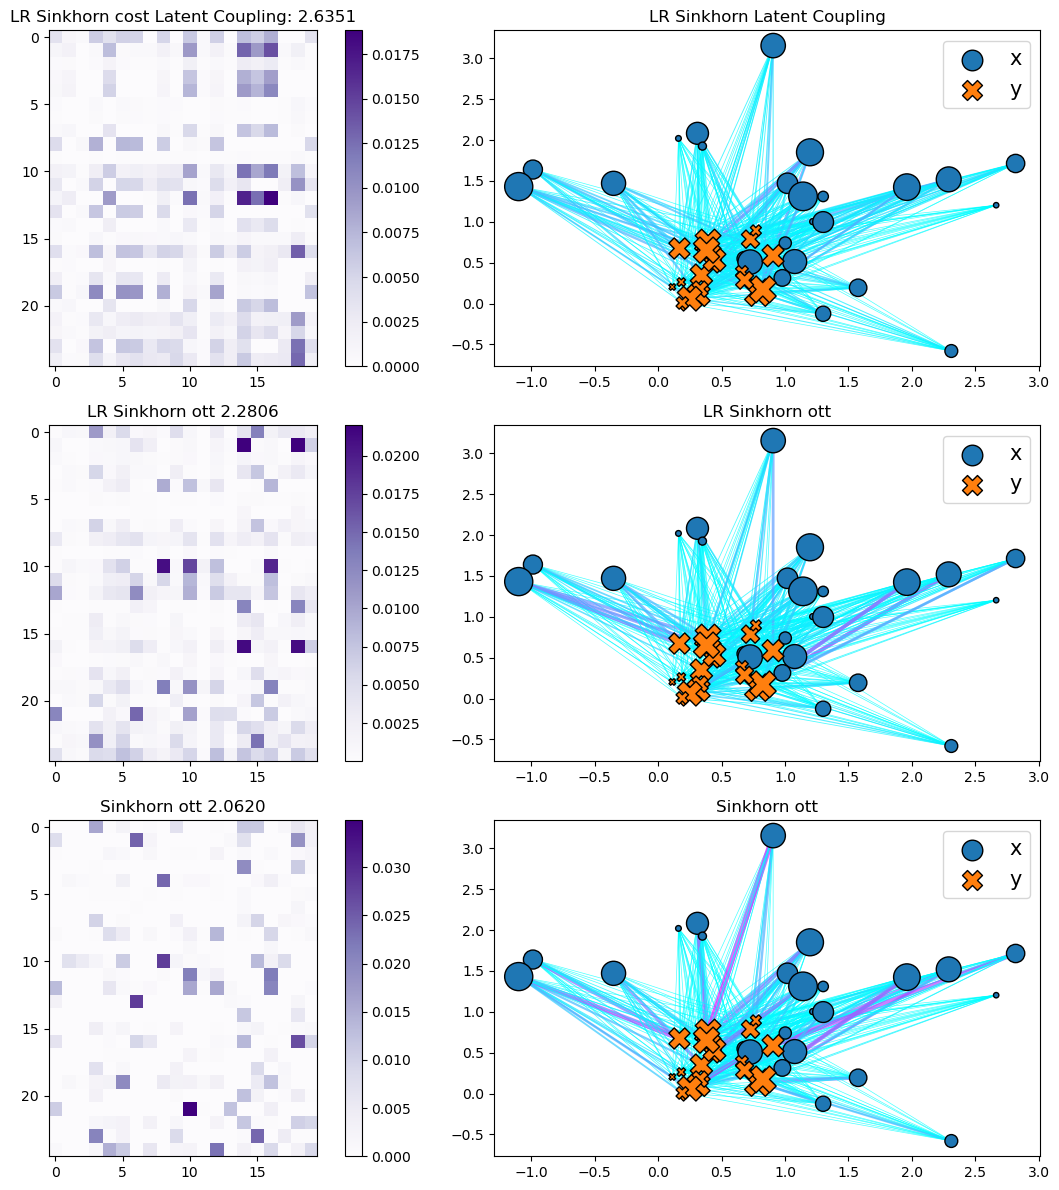

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Plot 1: LR Sinkhorn cost Latent Coupling (T.matrix)
axes[0, 0].imshow(T.matrix, cmap="Purples")
axes[0, 0].set_title(f"LR Sinkhorn cost Latent Coupling: {T.cost:.4f}")
fig.colorbar(axes[0, 0].images[0], ax=axes[0, 0])

# Plot 2: LR Sinkhorn Latent Coupling (plott(T))
plott = plot.Plot(title="LR sinkhorn Latent Coupling", ax=axes[0, 1])
plott(T)  # Use the axis argument for the plot
axes[0, 1].set_title("LR Sinkhorn Latent Coupling")

# Plot 3: LR Sinkhorn ott (ot_sink_lr.matrix)
axes[1, 0].imshow(ot_sink_lr.matrix, cmap="Purples")
axes[1, 0].set_title(f"LR Sinkhorn ott {ot_sink_lr.primal_cost:.4f}")
fig.colorbar(axes[1, 0].images[0], ax=axes[1, 0])

# Plot 4: LR Sinkhorn ott (plott(ot_sink_lr))
plott = plot.Plot(title="LR Sinkhorn ott", ax=axes[1, 1])  ## Closer look at the LC Coupling obtained)
plott(ot_sink_lr)  # Use the axis argument for the plot
axes[1, 1].set_title("LR Sinkhorn ott")

# Plot 5: Sinkhorn ott (ot_sink.matrix)
axes[2, 0].imshow(ot_sink.matrix, cmap="Purples")
axes[2, 0].set_title(f"Sinkhorn ott {ot_sink.primal_cost:.4f}")
fig.colorbar(axes[2, 0].images[0], ax=axes[2, 0])

# Plot 6: Sinkhorn ott (plott(ot_sink))
plott = plot.Plot(title="Sinkhorn ott", ax=axes[2, 1])
plott(ot_sink)  # Use the axis argument for the plot
axes[2, 1].set_title("Sinkhorn ott")

# Adjust layout
plt.tight_layout()
plt.show()


## Closer look at the LC Coupling obtained

We provide plots of the LC matricees, and at intermediary distributions obtained in the subdimensionnal space. We point out that, as the plot suggests, $Q$ and $R^T$ cannot be fully interpreted as compression/decompression matrices (which is behind the idea of the LC factorization, but not in the mirror descent implementation).

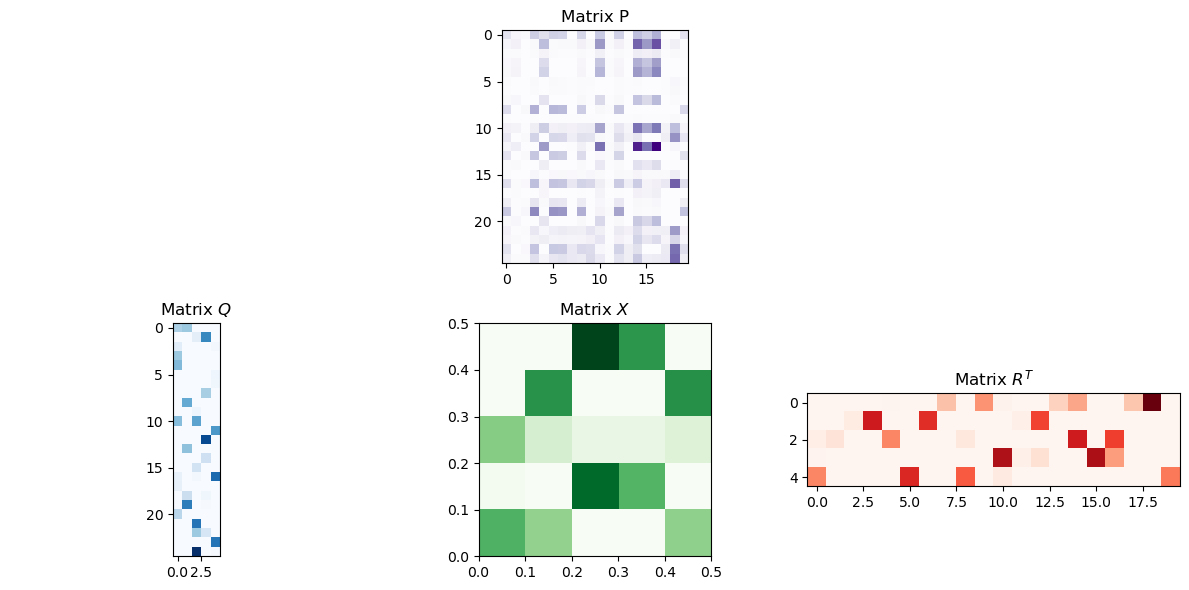

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # Create a 1x2 grid of subplots

# Plot P in the first cell
axes[0, 1].imshow(P, cmap="Purples")
axes[0, 1].set_title("Matrix P")
axes[0, 0].axis("off")  # Turn off the second cell in the first row
axes[0, 2].axis("off")
# fig.colorbar(axes[0].images[0], ax=axes[0])

# Overlay Q, X, and R in the second cell
axes[1][0].imshow(Q, cmap="Blues", alpha=0.6, label="Matrix Q")  # Plot Q
axes[1][1].imshow(X, cmap="Greens", alpha=0.6, label="Matrix X")  # Plot X
axes[1][2].imshow(R.T, cmap="Reds", alpha=0.6, label="Matrix R")  # Plot R
# axes[1].set_title("Matrices Q, X, and R (overlaid)")
# axes[1].legend(["Matrix Q", "Matrix X", "Matrix R"])  # Add a legend

axes[1, 0].imshow(Q, cmap="Blues")
axes[1, 0].set_title(r"Matrix $Q$")

# Reduce the size of the matrix X on axes[1, 1]
axes[1, 1].imshow(X, cmap="Greens", extent=[0, 0.5, 0, 0.5])  # Adjust extent to shrink the display
axes[1, 1].set_title(r"Matrix $X$")

axes[1, 2].imshow(R.T, cmap="Reds")
axes[1, 2].set_title(r"Matrix $R^T$")


# Adjust layout
plt.tight_layout()
plt.show()


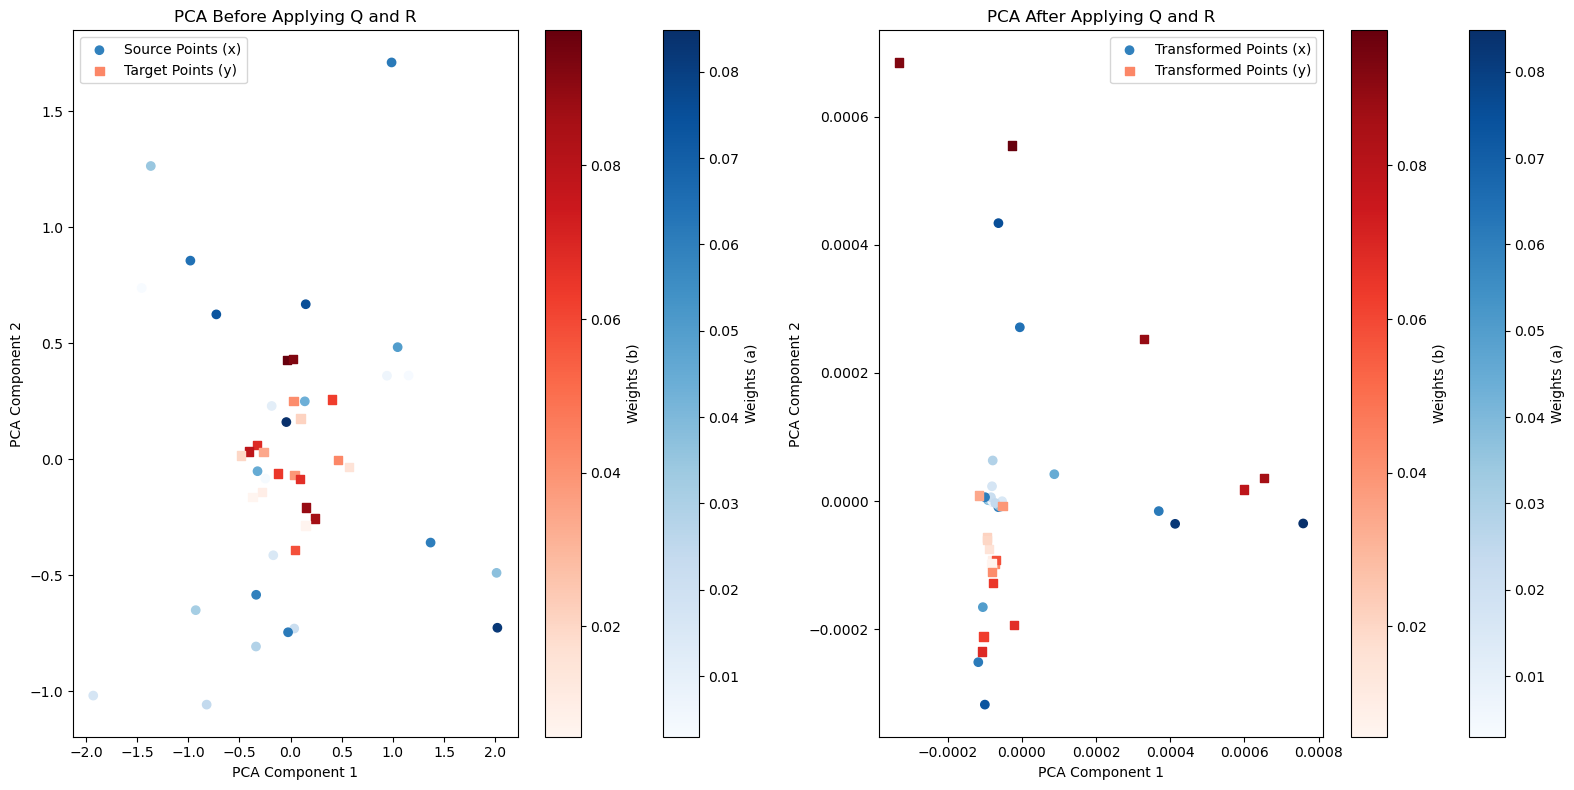

Shape of x_pca_before: (25, 2)
Shape of y_pca_before: (20, 2)
Shape of x_pca_after: (25, 2)
Shape of y_pca_after: (20, 2)


In [ ]:
def visualize_pca_before_after(
    Q: jnp.ndarray,
    R: jnp.ndarray,
    x: jnp.ndarray,
    y: jnp.ndarray,
    a: jnp.ndarray,
    b: jnp.ndarray,
    title_before: str = "Before OT",
    title_after: str = "After OT",
) -> None:
    """
    Compares the PCA of the vectors before and after applying Q and R.

    Args:
        Q (jnp.ndarray): Latent transport matrix for x (n x r).
        R (jnp.ndarray): Latent transport matrix for y (m x r).
        x (jnp.ndarray): Points from the source distribution (n x d).
        y (jnp.ndarray): Points from the target distribution (m x d).
        a (jnp.ndarray): Weights associated with source points (n,).
        b (jnp.ndarray): Weights associated with target points (m,).
        title_before (str): Title for visualization before applying Q and R.
        title_after (str): Title for visualization after applying Q and R.
    """

    # PCA before applying Q and R
    pca_before = PCA(n_components=2)
    x_pca_before = pca_before.fit_transform(x)
    y_pca_before = pca_before.fit_transform(y)

    x_after = (Q * a[:, None]) @ Q.T
    y_after = (R * b[:, None]) @ R.T

    # PCA after
    pca_after_x = PCA(n_components=2)
    x_pca_after = pca_after_x.fit_transform(x_after)

    pca_after_y = PCA(n_components=2)
    y_pca_after = pca_after_y.fit_transform(y_after)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Before
    scatter_x_before = axes[0].scatter(
        x_pca_before[:, 0],
        x_pca_before[:, 1],
        c=a,
        cmap="Blues",
        label="Source Points (x)",
    )
    scatter_y_before = axes[0].scatter(
        y_pca_before[:, 0],
        y_pca_before[:, 1],
        c=b,
        cmap="Reds",
        label="Target Points (y)",
        marker="s",
    )
    axes[0].set_title(title_before)
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    plt.colorbar(scatter_x_before, ax=axes[0], label="Weights (a)")
    plt.colorbar(scatter_y_before, ax=axes[0], label="Weights (b)")
    axes[0].legend()

    # After
    scatter_x_after = axes[1].scatter(
        x_pca_after[:, 0],
        x_pca_after[:, 1],
        c=a,
        cmap="Blues",
        label="Transformed Points (x)",
    )
    scatter_y_after = axes[1].scatter(
        y_pca_after[:, 0],
        y_pca_after[:, 1],
        c=b,
        cmap="Reds",
        label="Transformed Points (y)",
        marker="s",
    )
    axes[1].set_title(title_after)
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2")
    plt.colorbar(scatter_x_after, ax=axes[1], label="Weights (a)")
    plt.colorbar(scatter_y_after, ax=axes[1], label="Weights (b)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    print(f"Shape of x_pca_before: {x_pca_before.shape}")
    print(f"Shape of y_pca_before: {y_pca_before.shape}")
    print(f"Shape of x_pca_after: {x_pca_after.shape}")
    print(f"Shape of y_pca_after: {y_pca_after.shape}")


visualize_pca_before_after(
    Q,
    R,
    x,
    y,
    a,
    b,
    title_before="PCA Before Applying Q and R",
    title_after="PCA After Applying Q and R",
)


We see the next steps towards integrating this solver to the ott library as:
- Computing some semi-relaxed projection in the log space.
- Make all functions jitable (notably reformulating the while loop).
- Encapsulate the code to match the ott library backbone.